In [1]:
import pennylane as qml
import pandas as pd
from qco_level_0 import *
from qco_level_1 import optimization_level_1
from qco_level_2 import optimization_level_2
from qco_spec_table import make_spec_table
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
[ds] = qml.data.load("ketgpt")

In [3]:
# example
seed = 2
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        if op.name == 'QubitUnitary':
            continue
        qml.apply(op)
    return qml.state()

qnode_q2 = optimization_level_2(circuit)
qnode_q1 = optimization_level_1(qnode_q2)
qnode_q2 = optimization_level_2(qnode_q1)
df = make_spec_table(circuit, qnode_q2)
df

,Original,Qiskit\n(pattern matching),Qiskit,PennyLane,Level 2+1+2
gates,441,407,247,248,272
1q gates,280,256,98,97,121
2q gates,161,151,149,151,151
depth,98,94,76,76,77
gate types,6,5,5,5,6


In [4]:
dfs = []
for seed in range(len(ds.circuits)):
    @qml.qnode(qml.device('default.qubit'))
    def circuit():
        for op in ds.circuits[seed]:
            if op.name == 'QubitUnitary':
                continue
            qml.apply(op)
        return qml.state()
    try:
        qnode_q2 = optimization_level_2(circuit)
        qnode_q1 = optimization_level_1(qnode_q2)
        qnode_q2 = optimization_level_2(qnode_q1)
        df = make_spec_table(circuit, qnode_q2)
        dfs.append(df)
    except:
        pass

In [5]:
len(dfs)                                    

1000

In [6]:
dfs[0]

,Original,Qiskit\n(pattern matching),Qiskit,PennyLane,Level 2+1+2
gates,141,131,41,41,51
1q gates,116,106,22,22,32
2q gates,25,25,19,19,19
depth,32,32,18,18,16
gate types,5,4,4,4,4


In [15]:
dfs_copy = dfs.copy()
dfs_ratio = []
for idx, df in enumerate(dfs_copy):
    df = df.rename(columns={'Qiskit(pattern matching)':'Qiskit\n(pattern matching)'})
    df = df.rename(columns={'Level 2+1+2':'Level\n2+1+2'})
    dfs_ratio.append(df.div(df['Original'], axis=0).round(3))
dfs_ratio = [df.drop(columns='Original') for df in dfs_ratio]
dfs_ratio[0]

,Qiskit\n(pattern matching),Qiskit,PennyLane,Level\n2+1+2
gates,0.929,0.291,0.291,0.362
1q gates,0.914,0.190,0.190,0.276
2q gates,1.000,0.760,0.760,0.760
depth,1.000,0.562,0.562,0.500
gate types,0.800,0.800,0.800,0.800


In [16]:
records = []
for df in dfs_ratio:
    for metric in df.index:
        for method in df.columns:
            records.append({
                'metric': metric,
                'method': method,
                'ratio': df.loc[metric, method]
            })

long_df = pd.DataFrame(records)

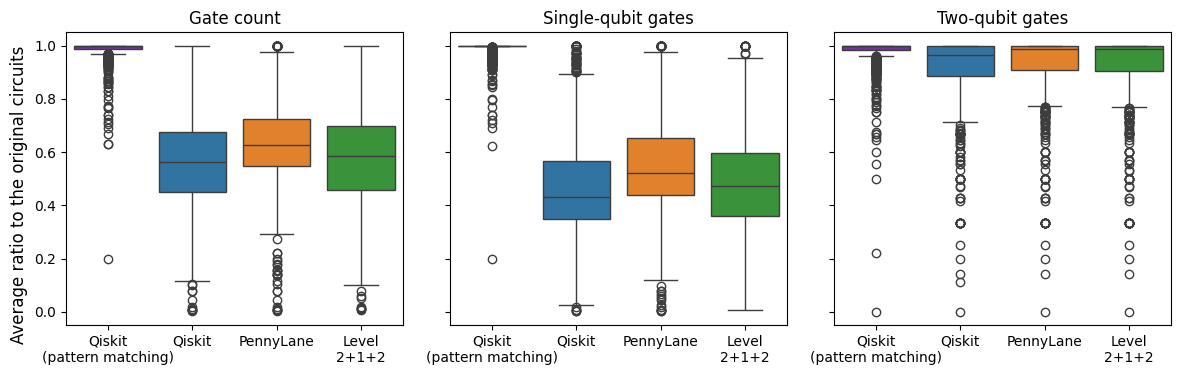

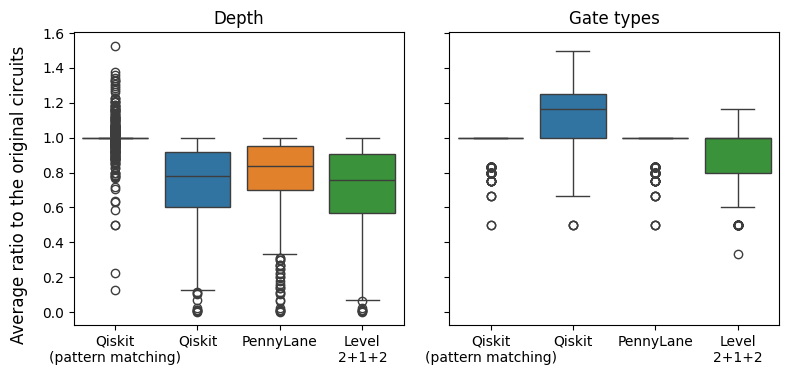

In [17]:
# fig 1
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for i, metric in enumerate(['gates', '1q gates', '2q gates']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit\n(pattern matching)':'#7b1fb4','Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'Level\n2+1+2': '#2ca02c'})
    if i==0:
        ax.set_title('Gate count')
    elif i==1:
        ax.set_title('Single-qubit gates')
    elif i==2:
        ax.set_title('Two-qubit gates')
    ax.set_xlabel('') 
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

# fig 1
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for i, metric in enumerate(['depth','gate types']):
    ax = axes.flatten()[i]
    subset = long_df[long_df['metric'] == metric]
    sns.boxplot(data=subset, y='ratio', x='method', hue='method', ax=ax, palette={'Qiskit\n(pattern matching)':'#7b1fb4','Qiskit': '#1f77b4', 'PennyLane': '#ff7f0e', 'Level\n2+1+2': '#2ca02c'})
    if i==0:
        ax.set_title('Depth')
    elif i==1:
        ax.set_title('Gate types')
    ax.set_xlabel('') 
    ax.set_ylabel('') 
fig.supylabel('Average ratio to the original circuits')
fig.supxlabel('')
plt.tight_layout()
plt.show()

In [18]:
long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()

,method,metric,mean
0,Level\n2+1+2,1q gates,0.490753
1,Level\n2+1+2,2q gates,0.927102
2,Level\n2+1+2,depth,0.721330
3,Level\n2+1+2,gate types,0.906111
4,Level\n2+1+2,gates,0.575416
5,PennyLane,1q gates,0.556913
6,PennyLane,2q gates,0.929081
7,PennyLane,depth,0.796900
8,PennyLane,gate types,0.974584
9,PennyLane,gates,0.637766


In [19]:
long_df.groupby(['method','metric'])['ratio'].agg(['std']).reset_index()

,method,metric,std
0,Level\n2+1+2,1q gates,0.191748
1,Level\n2+1+2,2q gates,0.135612
2,Level\n2+1+2,depth,0.216954
3,Level\n2+1+2,gate types,0.143716
4,Level\n2+1+2,gates,0.181626
5,PennyLane,1q gates,0.190527
6,PennyLane,2q gates,0.133014
7,PennyLane,depth,0.196185
8,PennyLane,gate types,0.070055
9,PennyLane,gates,0.165749


In [20]:
min_df = long_df.groupby(['method','metric'])['ratio'].agg(['mean']).reset_index()
min_df['mean'] = (1-min_df['mean'])*100
min_df

,method,metric,mean
0,Level\n2+1+2,1q gates,50.924700
1,Level\n2+1+2,2q gates,7.289840
2,Level\n2+1+2,depth,27.867000
3,Level\n2+1+2,gate types,9.388900
4,Level\n2+1+2,gates,42.458400
5,PennyLane,1q gates,44.308700
6,PennyLane,2q gates,7.091872
7,PennyLane,depth,20.310000
8,PennyLane,gate types,2.541600
9,PennyLane,gates,36.223400
